![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor


# 1. ЧЕМ МЫ БУДЕМ ЗАНИМАТЬСЯ?
Создадим модель, использующую алгоритмы машинного обучения.Код для создания и обучения модели предоставлен в готовом виде: в нём не будет предусмотрен подбор параметров и тонкая настройка модели. **Алгоритм машинного обучения — RandomForestRegression. 
Наша задача состоит в том, чтобы качественно подготовить данные для обучения модели.**
Очистка данных и генерация новых признаков (Feature Engineering) способны значительно повысить точность модели.

## КАКОЙ КЕЙС РЕШАЕМ?
Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.
Вам поставлена задача создать такую модель.


# 2. Разбираемся с данными

Датасет содержит сведения о 40 000 ресторанах Европы, а модель, которую мы будем обучать, должна будет предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:
* Restaurant_id — идентификационный номер ресторана / сети ресторанов;
* City — город, в котором находится ресторан;
* Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* Price Range — диапазон цен в ресторане;
* Number of Reviews — количество отзывов о ресторане;
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvisor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

## Что мы сделаем на этом шаге?
* Загрузим необходимыме библиотеки.
* Загрузим тренировочный и тестовый датасеты.
* Посмотрим на данные.
* Посмотрим, где у нас пропуски.
* Определим тип признаков.

# import

In [1]:
# This Python 3 environment comes with helpful analytics libraries installed
# It is defined by the kaggle/python docker image:
# https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import Counter
import re
import datetime
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter)
# will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA
Загрузим тренировочный и тестовый датасеты

In [4]:
# DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


Таким образом, тренировочный и тестовый датасеты содержат 40000 и 10000 записей соответственно. Оба датасета имеют пропуски в данных.

* df_train имеет пропуски в признаках: 'Cuisine Style', 'Price Range', 'Number of Reviews'
* df_test имеет пропуски в признаках: 'Cuisine Style', 'Price Range', 'Number of Reviews', 'Reviews'



In [9]:
sample_submission.head(5)
# пример файла с результатами моделирования:
# для ресторанов ('Restaurant_id') прогнозируется рейтинг ('Rating')

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать,
# поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [13]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# 3. Очистка и предварительная обработка

# Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью.В этом проекте пропуски не удаляем, а заполняем. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

## Cтолбец 'Number of Reviews'

In [15]:
# создаем признак 'Number_of_Reviews_isNAN',который содержит инфо о пропусках
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number of Reviews']).astype('uint8')

In [16]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [17]:
# Далее заполняем пропуски 0
data['Number of Reviews'].fillna(0, inplace=True)

In [18]:
# проверяем:
data['Number of Reviews'].isna().value_counts()

False    50000
Name: Number of Reviews, dtype: int64

## Cтолбец 'Price Range'

In [19]:
# создаем признак 'Price Range_isNAN',который содержит инфо о пропусках
data['Price Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

In [20]:
# для заполнения пропусков находим самое распространенное значение признака:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [21]:
# Заполняем пропуски средним ценовым диапазоном:
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

In [22]:
# проверяем:
data['Price Range'].isna().value_counts()

False    50000
Name: Price Range, dtype: int64

## Cтолбец 'Cuisine Style'

In [23]:
# создаем признак 'Cuisine Style_isNAN',который содержит инфо о пропусках
data['Cuisine Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [24]:
data['Cuisine Style_isNAN'].value_counts()

0    38410
1    11590
Name: Cuisine Style_isNAN, dtype: int64

In [25]:
# заполняем пропуски 'European' с "лишними" символами, как и в других ячейках
data['Cuisine Style'] = data['Cuisine Style'].fillna("['European']")

In [26]:
# проверяем:
data['Cuisine Style'].isna().value_counts()

False    50000
Name: Cuisine Style, dtype: int64

# 4. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [27]:
 data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10731
Ranking                    12975
Price Range                    3
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
Price Range_isNAN              2
Cuisine Style_isNAN            2
dtype: int64

В качестве категориальных рассмотрим признаки:
*  'City' - 31 город в датасете - закодируем
* 'Price Range'- 3 градации - заменим последовательными числами 1,2,3;

# Столбец 'City'



In [28]:
# Сначала делаем копию столбца 'City' - она нам потом пригодится
data['City_Copy'] = data['City']

In [29]:
# количество городов в датасете
amount_of_cities = len(data['City'].unique())
# переводим города в dummy-переменные,'nan' не используем,
# т.к. признак 'City' не имеет пропусков
# для кодирования используем подход "One-Hot Encoding"
data = pd.get_dummies(data, columns=['City'],
                      prefix='', prefix_sep='', dummy_na=False)
city_sum = {} #создаем словарь с количеством ресторанов по городам
for city in data.columns[-amount_of_cities:]:
    city_sum[city] = data[city].sum()
print("количество ресторанов по городам:", city_sum)

количество ресторанов по городам: {'Amsterdam': 1372, 'Athens': 776, 'Barcelona': 3395, 'Berlin': 2705, 'Bratislava': 380, 'Brussels': 1314, 'Budapest': 1021, 'Copenhagen': 819, 'Dublin': 836, 'Edinburgh': 745, 'Geneva': 590, 'Hamburg': 1186, 'Helsinki': 475, 'Krakow': 554, 'Lisbon': 1647, 'Ljubljana': 222, 'London': 7193, 'Luxembourg': 263, 'Lyon': 1126, 'Madrid': 3813, 'Milan': 2694, 'Munich': 1145, 'Oporto': 642, 'Oslo': 488, 'Paris': 6108, 'Prague': 1816, 'Rome': 2589, 'Stockholm': 1033, 'Vienna': 1443, 'Warsaw': 925, 'Zurich': 685}


In [30]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
13973,id_985,"['French', 'American']",986.0,$$ - $$$,2.0,"[[], []]",/Restaurant_Review-g189180-d5977490-Reviews-Re...,d5977490,1,5.0,...,0,1,0,0,0,0,0,0,0,0
12126,id_275,"['Delicatessen', 'Portuguese', 'Vegetarian Fri...",276.0,$$ - $$$,477.0,"[['Worth the climb!', 'So charming in the sun....",/Restaurant_Review-g189158-d1419011-Reviews-Fa...,d1419011,1,4.0,...,0,0,0,0,0,0,0,0,0,0
42036,id_869,['European'],870.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g274856-d12404708-Reviews-P...,d12404708,1,5.0,...,0,0,0,0,0,0,0,0,1,0
979,id_979,"['Italian', 'Mediterranean', 'European', 'Wine...",394.0,$$ - $$$,1312.0,"[['Great lunch', 'A local favorite just off th...",/Restaurant_Review-g187791-d2330277-Reviews-Il...,d2330277,0,0.0,...,0,0,0,0,0,1,0,0,0,0
36932,id_8077,"['Bar', 'British', 'Pub']",8086.0,$$ - $$$,130.0,"[['Fine end to a snowy day', 'Great pub'], ['1...",/Restaurant_Review-g186338-d5243086-Reviews-Ri...,d5243086,1,3.5,...,0,0,0,0,0,0,0,0,0,0


# Столбец "Price Range"

In [31]:
data['Price Range'].value_counts()

$$ - $$$    40402
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [32]:
def price_marker(price):
    # функция маркировки цен порядковыми числами 1, 2, 3:
    if price == '$':
        price = 1
        return price
    elif price == '$$$$':
        price = 3
        return price
    price = 2
    return price

# создаем новый признак - маркированные цены:
data['Price marked'] = data['Price Range'].apply(price_marker)

In [33]:
# цель следующего шага -
# получить новый признак "количество видов кухонь в ресторане"
# для этого чистим строки от ненужных символов и преобразовываем в списки:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: str(x)[1:-1])
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.replace("'",""))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.replace(" ",""))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.split(","))

# Столбец 'Cuisine Style'

In [34]:
# новый признак - "количество видов кухонь в ресторане":
data['Number of Cuisines'] = data['Cuisine Style'].apply(lambda x: len(x))

In [35]:
# составим список всех уникальных кухонь в датасете:
cuisine_list = []
for i in data['Cuisine Style']:
    for j in i:
        cuisine_list.append(j)
# создаем словарь с уникальными кухнями:
cuisine_collections = Counter(cuisine_list)
# из этого список уникальных кухонь:
cuisine_list = list(cuisine_collections.keys())
print("в датасете {} уникальных кухонь".format(len(cuisine_list)))

в датасете 125 уникальных кухонь


In [36]:
# посмотрим кухни и их количество:
cuisine_collections

Counter({'Bar': 4094,
         'Pub': 3058,
         'European': 24151,
         'Scandinavian': 449,
         'GlutenFreeOptions': 5185,
         'VegetarianFriendly': 14021,
         'VeganOptions': 5684,
         'Italian': 7433,
         'Mediterranean': 7820,
         'Seafood': 1878,
         'French': 3970,
         'Cafe': 2883,
         'FastFood': 2122,
         'Portuguese': 1385,
         'Greek': 768,
         'Czech': 745,
         'EasternEuropean': 629,
         'CentralEuropean': 1727,
         'Pizza': 3502,
         'British': 1992,
         'Spanish': 3456,
         'Norwegian': 96,
         'African': 193,
         'Moroccan': 173,
         'MiddleEastern': 980,
         'Halal': 773,
         'Indian': 1328,
         'Thai': 923,
         'Dutch': 368,
         'Welsh': 3,
         'American': 1642,
         'Steakhouse': 729,
         'Soups': 630,
         'Scottish': 199,
         'Fusion': 748,
         'StreetFood': 336,
         'Hungarian': 444,
         'A

In [37]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Price marked,Number of Cuisines
0,id_0,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,1,0,0,0,0,0,0,2,2
1,id_1,"[European, Scandinavian, GlutenFreeOptions, Ve...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,2,5
2,id_2,[VegetarianFriendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,2,1
3,id_3,"[Italian, Mediterranean, European, VegetarianF...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,3,5
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,3,6


# Столбец 'Reviews'

In [38]:
# обрабатываем признак 'Reviews':
# выделяем из него даты и переводим в формат Datetime
pattern = re.compile('\d\d/\d\d/\d\d\d\d')
data['Reviews'] = data['Reviews'].fillna('')
data['Review_dates'] = data['Reviews'].apply(lambda x: pattern.findall(x))
data['Review_1'] = data['Review_dates'].apply(lambda x: x[:1])
data['Review_2'] = data['Review_dates'].apply(lambda x: x[1:])

In [39]:
# заполняем пропуски самым частым значением для каждого столбца ревью:
for i in range(len(data['Review_1'])):
    if len(data['Review_1'][i]) == 0:
        data['Review_1'][i].append('01/07/2018')
for i in range(len(data['Review_2'])):
    if len(data['Review_2'][i]) == 0:
        data['Review_2'][i].append('01/03/2018')

In [40]:
# переводим в формат Datetime:
data['Review_1'] = data['Review_1'].apply(
                   lambda x: datetime.strptime(x[0], '%m/%d/%Y'))
data['Review_2'] = data['Review_2'].apply(
                   lambda x: datetime.strptime(x[0], '%m/%d/%Y'))
data.drop(['Review_dates'], axis=1, inplace=True)

In [41]:
# создаем новый признак 'Review_Delta' с разницей в днях между ревью:
data['Review_Delta'] = data['Review_1'] - data['Review_2']
data['Review_Delta'] = data['Review_Delta'].apply(lambda x: x.days)

In [42]:
# создаем новый признак 'How_old_Review':
# старость ревью относительно самого свежего:
newest_review = data['Review_1'].max()
data['How_old_Review'] = data['Review_1'].apply(
                         lambda x: (newest_review - x).days)

In [43]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Stockholm,Vienna,Warsaw,Zurich,Price marked,Number of Cuisines,Review_1,Review_2,Review_Delta,How_old_Review
0,id_0,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,2,2,2018-01-07,2018-01-03,4,50
1,id_1,"[European, Scandinavian, GlutenFreeOptions, Ve...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,2,5,2017-12-05,2017-10-29,37,83
2,id_2,[VegetarianFriendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,2,1,2017-12-28,2017-12-06,22,60
3,id_3,"[Italian, Mediterranean, European, VegetarianF...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,3,5,2017-12-06,2017-11-22,14,82
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,3,6,2018-02-08,2018-01-24,15,18


# Новый признак 'Relative_Ranking'- 
отношение ранга ресторана к количеству ресторанов в этом городе  по данным датасета

In [44]:
# создаем признак 'Relative_Ranking' -
# ранг относителько количества ресторанов в этом городе:
def rel_rank(row, c_s):
    #функция деления ранга ресторана на количество ресторанов
    # в городе по данным датасета
    for i in c_s.keys():
        if row[i] == 1:
            res = row['Ranking']/c_s[i]
    return res

data['Relative_Ranking'] = data.apply(lambda x: rel_rank(x, city_sum), axis=1)

## Создаем новые признаки в отношении к населению города

In [45]:
# население городов с агломерациями по данным wikipedia.org
# нашел и ввел вручную
popul_data = {'Amsterdam':827, 'Athens':3168, 'Barcelona':3186,
              'Berlin':6177, 'Bratislava':700, 'Brussels':1831,
              'Budapest':2965, 'Copenhagen':1308, 'Dublin':1347,
              'Edinburgh':507, 'Geneva':496, 'Hamburg':1841,
              'Helsinki':1299, 'Krakow':1200, 'Lisbon':3000,
              'Ljubljana':508, 'London':8416, 'Luxembourg':162,
              'Lyon':1748, 'Madrid':3266, 'Milan':3218,
              'Munich':1471, 'Oporto':237, 'Oslo':1558,
              'Paris':10620, 'Prague':1301, 'Rome':3900,
              'Stockholm':2352, 'Vienna':1897, 'Warsaw':3100,
              'Zurich':1334}

In [46]:
# создаем признак 'Population' - население в тыс. жителей:
def city_popul(row, p_d):
    #функция возвращает значение населения в зависимости от названия города
    for i in p_d.keys():
        if row[i] == 1:
            res = p_d[i]
    return res

data['Population'] = data.apply(lambda x: city_popul(x, popul_data), axis=1)

In [47]:
# создаем признак 'Review to Population' -
# отношение количества отзывов к населению:
data['Review to Population'] = data['Number of Reviews'] / data['Population']

In [48]:
# создаем признак 'Rel_Rank to Population' -
# отношение относительного ранга к населению:
data['Rel_Rank to Population'] = data['Relative_Ranking'] / data['Population']

# EDA 
## Exploratory Data Analysis

### Посмотрим распределение признака

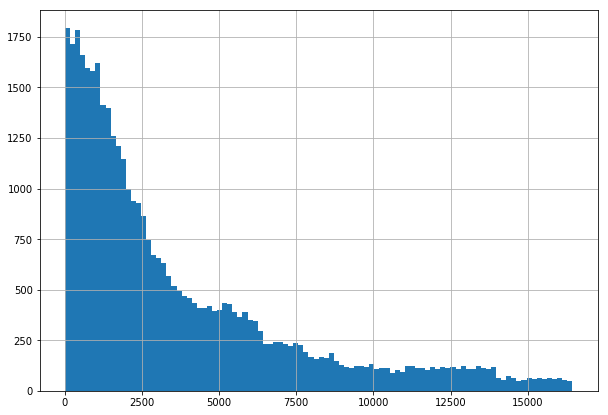

In [49]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

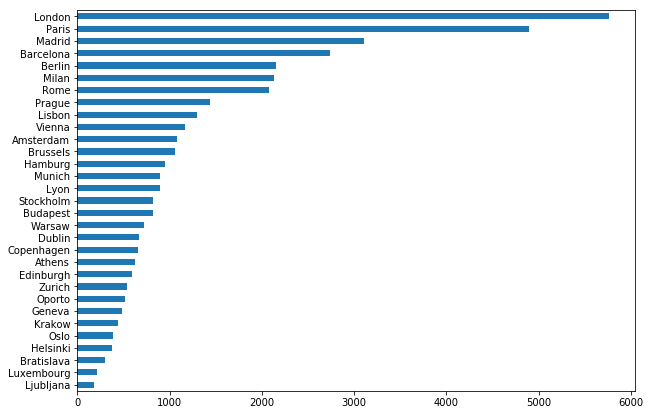

In [50]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

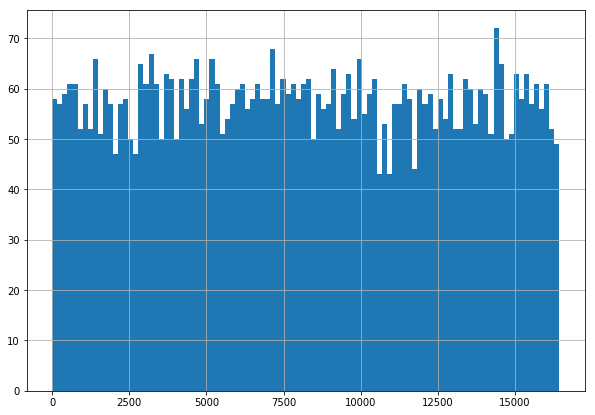

In [51]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

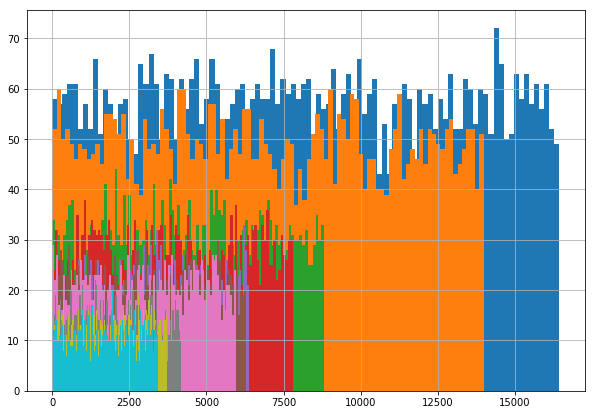

In [52]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.


### Посмотрим распределение целевой переменной

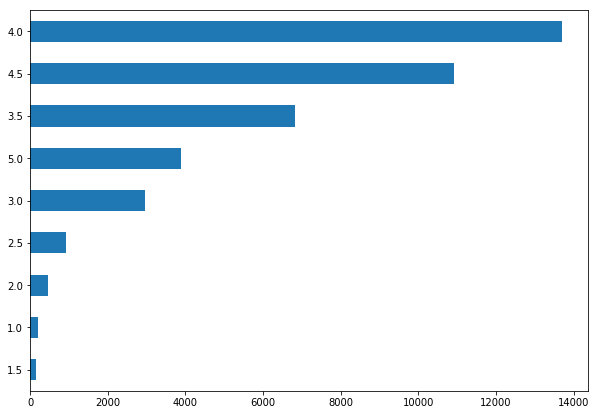

In [53]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

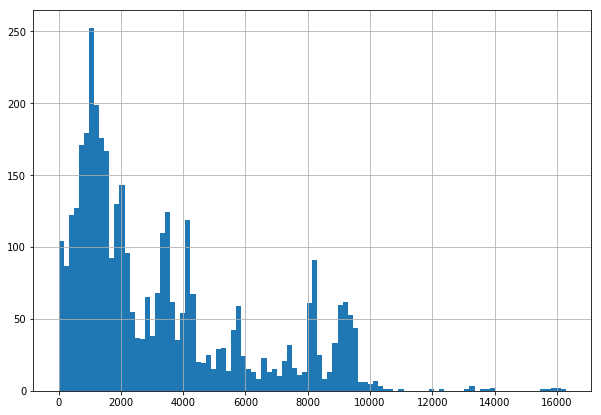

In [54]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

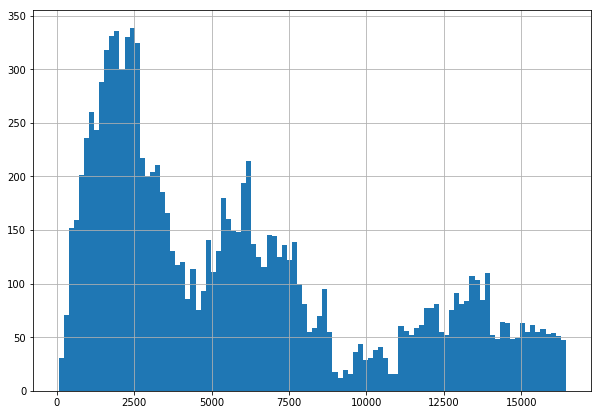

In [55]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

## Сопоставим города и рейтинги при помощи boxplot:

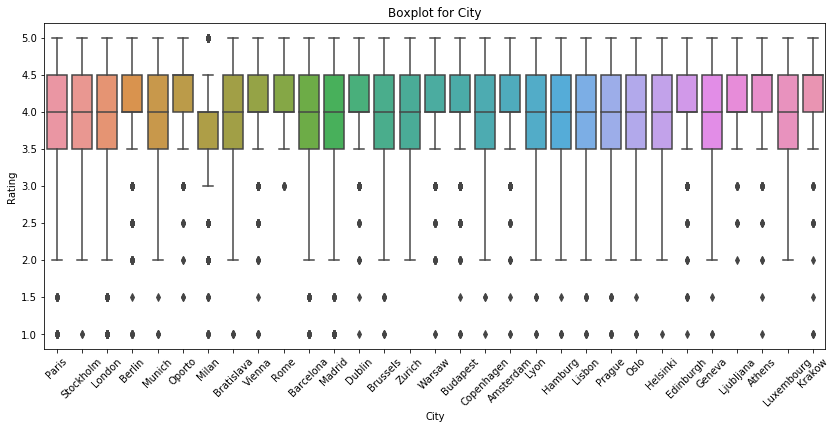

In [56]:
# рейтинг по городам:
fig, ax = plt.subplots(figsize = (14, 6))
sns.boxplot(x='City', y='Rating', data=df_train, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot for ' + 'City')
plt.show()

На боксплоте видно, что среднее значение рейтинга 4.0, не зависит от города. Точки-"выбросы" выбросами не считаем, так как они вписываются в пределы 0...5

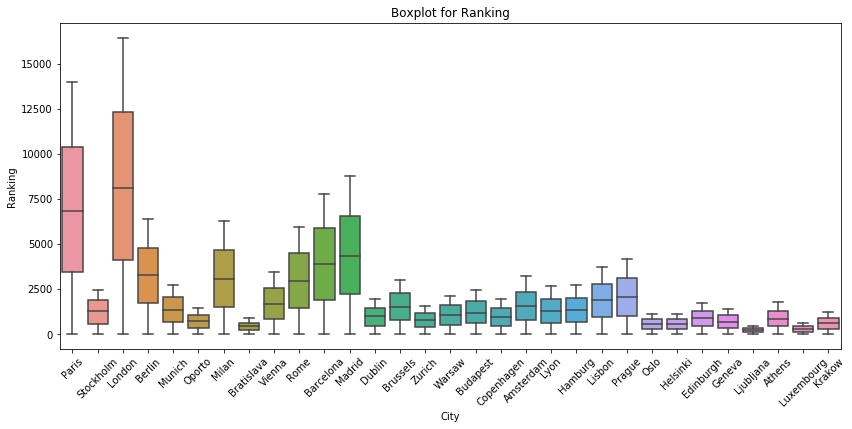

In [57]:
# ранги ресторанов по городам
fig, ax = plt.subplots(figsize = (14, 6))
sns.boxplot(x='City', y='Ranking', data=df_train, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot for ' + 'Ranking')
plt.show()

Явно видно, что абсолютные значения ранга сильно зависят от размера города (количества ресторанов в нем).
Посмотрим теперь в относительных значениях:

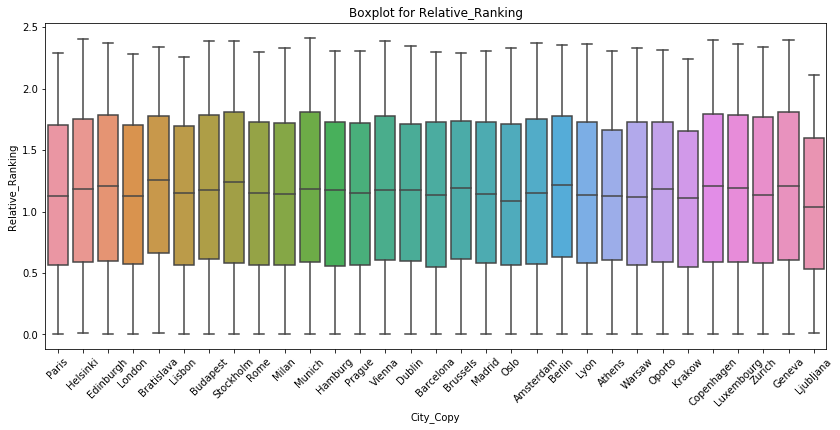

In [58]:
# относительный ранг ресторанов по городам
# его берем не из датасета df_train, а из датасета data,
# так как в data создан новый признак -
# "отношение ранга ресторана к количеству ресторанов в этом городе":
fig, ax = plt.subplots(figsize = (14, 6))
sns.boxplot(x='City_Copy', y='Relative_Ranking', data=data, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot for ' + 'Relative_Ranking')
plt.show()

Видно, что распределение относительного ранга практически не зависит от города

# Матрица корреляций

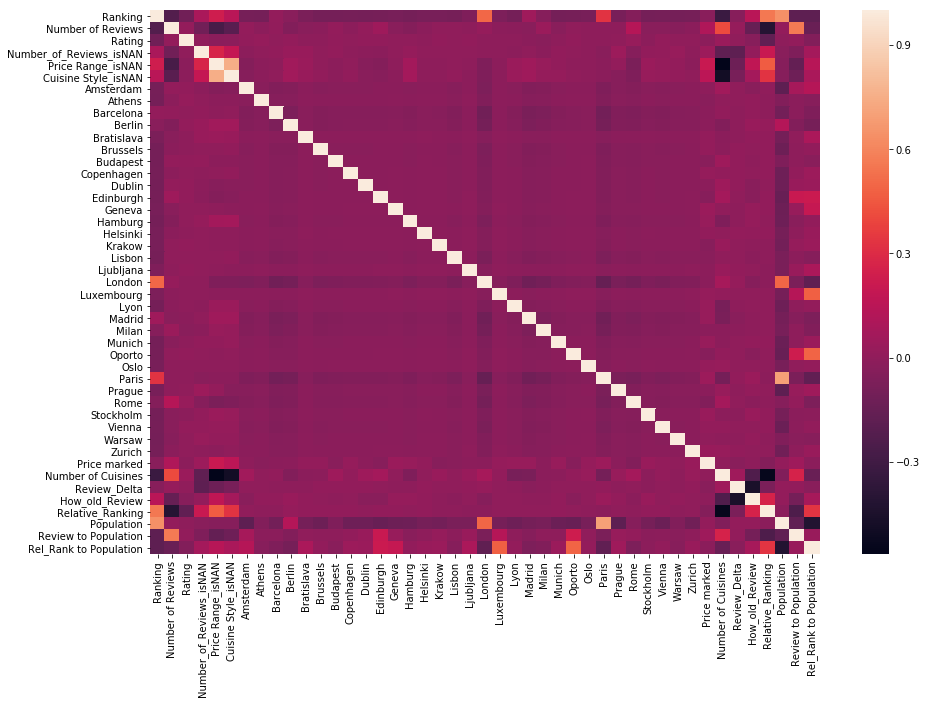

In [59]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

1. Из матрицы видно, что нет ни одного признака, от которого сильно зависит целевая переменная 'Rating'. Есть корреляция между признаками 'Price Range_isNAN' и 'Cuisine Style_isNAN'. Вероятно, по одним и тем же ресторанам есть пропуски в данных по ценам и по кухням одновременно. Аналогично синхронными пропусками в данных можно объяснить обратную зависимость между 'Number of Cuisines' и  'Price Range_isNAN' и 'Cuisine Style_isNAN'. Есть зависимость средней силы между рангом 'Ranking' и населением города 'Population'. В целом, мультиколлинеарности не видно, оставляем все признаки для использования в модели.

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [60]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать,
                      # поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
# data.info()

In [61]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##########################
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)

    # ################### 2. NAN ####################################
    # Заполняем пропуски (попутно создавая признаки, которые показывают пропуски):
    df_output['Number_of_Reviews_isNAN'] = pd.isna(
                                   df_output['Number of Reviews']).astype('uint8')
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # пропуски в ценах заполняем самым массовым - средним ценовым диапазоном:
    df_output['Price Range_isNAN'] = pd.isna(
                                    df_output['Price Range']).astype('uint8')
    df_output['Price Range'] = df_output['Price Range'].fillna('$$ - $$$')
    # пропуски в кухнях заполняем тремя самыми массовыми,
    # так как заполнение тремя кухнями дает лучший МАЕ, чем заполнение одной кухней
    df_output['Cuisine Style_isNAN'] = pd.isna(
                                       df_output['Cuisine Style']).astype('uint8')
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna(
                         "['European', 'Vegetarian Friendly', 'International']")

    # ################### 3. Encoding #############################
    # переводим города в dummy-переменные:
    amount_of_cities = len(df_output['City'].unique())
    df_output = pd.get_dummies(df_output, columns=['City'],
                               prefix='', prefix_sep='',dummy_na=False)
    city_sum = {}
    for city in df_output.columns[-amount_of_cities:]:
        city_sum[city] = df_output[city].sum()

    # ################### 4. Feature Engineering ##################
    def price_marker(price):
        # функция маркировки цен порядковыми числами 1, 2, 3
        if price == '$':
            price = 1
            return price
        elif price == '$$$$':
            price = 3
            return price
        price = 2
        return price

    # создаем новый признак - маркированные цены
    df_output['Price marked'] = df_output['Price Range'].apply(price_marker)

    # цель следующего шага -
    # получить новый признак "количество видов кухонь в ресторане"
    # для этого чистим строки от лишних символов и преобразовываем в списки:
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(
                                 lambda x: str(x)[1:-1])
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(
                                 lambda x: x.replace("'",""))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(
                                 lambda x: x.replace(" ",""))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(
                                 lambda x: x.split(","))
    # новый признак - "количество видов кухонь в ресторане":
    df_output['Number of Cuisines'] = df_output['Cuisine Style'].apply(
                                      lambda x: len(x))

    # в ходе работы был составлен список всех уникальных кухонь в датасете
    # он не включен в выходные данные, поэтому приведен в виде комментария:
    # long_cuisine_list = []
    # for i in df_output['Cuisine Style']:
    #     for j in i:
    #         long_cuisine_list.append(j)
    # c = Counter(long_cuisine_list)
    # cuisine_list = list(c.keys())

    # обрабатываем признак 'Reviews':
    #выделяем из него даты и переводим в формат Datetime
    pattern = re.compile('\d\d/\d\d/\d\d\d\d')
    df_output['Reviews'] = df_output['Reviews'].fillna('')
    df_output['Review_dates'] = df_output['Reviews'].apply(
                                lambda x: pattern.findall(x))
    df_output['Review_1'] = df_output['Review_dates'].apply(lambda x: x[:1])
    df_output['Review_2'] = df_output['Review_dates'].apply(lambda x: x[1:])
    # заполняем пропуски самым частым значением для каждого столбца ревью:
    for i in range(len(df_output['Review_1'])):
        if len(df_output['Review_1'][i]) == 0:
            df_output['Review_1'][i].append('01/07/2018')
    for i in range(len(df_output['Review_2'])):
        if len(df_output['Review_2'][i]) == 0:
            df_output['Review_2'][i].append('01/03/2018')
    # переводим в формат Datetime:
    df_output['Review_1'] = df_output['Review_1'].apply(
                            lambda x: datetime.strptime(x[0], '%m/%d/%Y'))
    df_output['Review_2'] = df_output['Review_2'].apply(
                            lambda x: datetime.strptime(x[0], '%m/%d/%Y'))
    df_output.drop(['Review_dates'], axis=1, inplace=True)

    # создаем новый признак 'Review_Delta' с разницей в днях между ревью:
    df_output['Review_Delta'] = df_output['Review_1'] - df_output['Review_2']
    df_output['Review_Delta'] = df_output['Review_Delta'].apply(
                                lambda x: x.days)

    # создаем новый признак 'How_old_Review'-
    # старость ревью относительно самого свежего:
    newest_review = df_output['Review_1'].max()
    df_output['How_old_Review'] = df_output['Review_1'].apply(
                                  lambda x: (newest_review - x).days)

    # создаем признак 'Relative_Ranking' -
    # ранг относителько количества ресторанов в этом городе
    # по данным датасета:
    def rel_rank(row, c_s):
        # функция деления ранга ресторана на количество ресторанов
        # в городе по данным датасета
        for i in c_s.keys():
            if row[i] == 1:
                res = row['Ranking']/c_s[i]
        return res
    df_output['Relative_Ranking'] = df_output.apply(
                                    lambda x: rel_rank(x, city_sum), axis=1)

    # ################### Data from internet ################################
    # население городов с агломерациями по данным wikipedia.org
    # нашел и ввел вручную
    popul_data = {'Amsterdam':827, 'Athens':3168, 'Barcelona':3186,
                  'Berlin':6177, 'Bratislava':700, 'Brussels':1831,
                  'Budapest':2965, 'Copenhagen':1308, 'Dublin':1347,
                  'Edinburgh':507, 'Geneva':496, 'Hamburg':1841,
                  'Helsinki':1299, 'Krakow':1200, 'Lisbon':3000,
                  'Ljubljana':508, 'London':8416, 'Luxembourg':162,
                  'Lyon':1748, 'Madrid':3266, 'Milan':3218,
                  'Munich':1471, 'Oporto':237, 'Oslo':1558,
                  'Paris':10620, 'Prague':1301, 'Rome':3900,
                  'Stockholm':2352, 'Vienna':1897, 'Warsaw':3100,
                  'Zurich':1334}
    # создаем признак 'Population' - население в тыс. жителей:
    def city_popul(row, p_d):
        #функция возвращает значение населения в зависимости от названия города
        for i in p_d.keys():
            if row[i] == 1:
                res = p_d[i]
        return res
    df_output['Population'] = df_output.apply(
                              lambda x: city_popul(x, popul_data), axis=1)

    # создаем признак 'Review to Population' -
    # отношение количества отзывов к населению:
    df_output['Review to Population'] = df_output['Number of Reviews'] \
                                      / df_output['Population']

    # создаем признак 'Rel_Rank to Population' -
    # отношение относ. ранга к населению:
    df_output['Rel_Rank to Population'] = df_output['Relative_Ranking'] \
                                        / df_output['Population']


    # ################### 5. Clean ########################################
    # убираем признаки типов "object" и "Datetime"
    object_columns = [s for s in df_output.columns if \
                      df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)

    df_output.drop(['Review_1'], axis=1,inplace=True)
    df_output.drop(['Review_2'], axis=1, inplace=True)


    return df_output

#### Запускаем и проверяем что получилось

In [62]:
df_preproc = preproc_data(data)
df_preproc.head(3)

,Ranking,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Price Range_isNAN,Cuisine Style_isNAN,Amsterdam,Athens,Barcelona,...,Warsaw,Zurich,Price marked,Number of Cuisines,Review_Delta,How_old_Review,Relative_Ranking,Population,Review to Population,Rel_Rank to Population
0,12963.0,4.0,0,0.0,0,0,0,0,0,0,...,0,0,2,2,4,50,2.122299,10620,0.000377,0.000200
1,106.0,97.0,0,0.0,0,0,0,0,0,0,...,0,0,2,5,37,83,0.223158,1299,0.074673,0.000172
2,810.0,28.0,0,0.0,0,0,0,0,0,0,...,0,0,2,1,22,60,1.087248,507,0.055227,0.002144


In [63]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 46 columns):
Ranking                    50000 non-null float64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Price Range_isNAN          50000 non-null uint8
Cuisine Style_isNAN        50000 non-null uint8
Amsterdam                  50000 non-null uint8
Athens                     50000 non-null uint8
Barcelona                  50000 non-null uint8
Berlin                     50000 non-null uint8
Bratislava                 50000 non-null uint8
Brussels                   50000 non-null uint8
Budapest                   50000 non-null uint8
Copenhagen                 50000 non-null uint8
Dublin                     50000 non-null uint8
Edinburgh                  50000 non-null uint8
Geneva                     50000 non-null uint8
Hamburg              

In [64]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [65]:
# Воспользуемся функциеq train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
                                   X, y, test_size=0.2, random_state=RANDOM_SEED)

In [66]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 45), (40000, 45), (40000, 44), (32000, 44), (8000, 44))

# Model 
Сам ML

In [67]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [68]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(
        n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [69]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов
# в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [70]:
# округление рейтинга до 0.5
y_pred = (y_pred*2).round()/2
y_pred

array([4.5, 5. , 4.5, ..., 4.5, 4. , 4. ])

In [71]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test),
# и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает
# среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.16875


In [72]:
# MAE=0.16875 < MAE=0.21 in baseline notebook

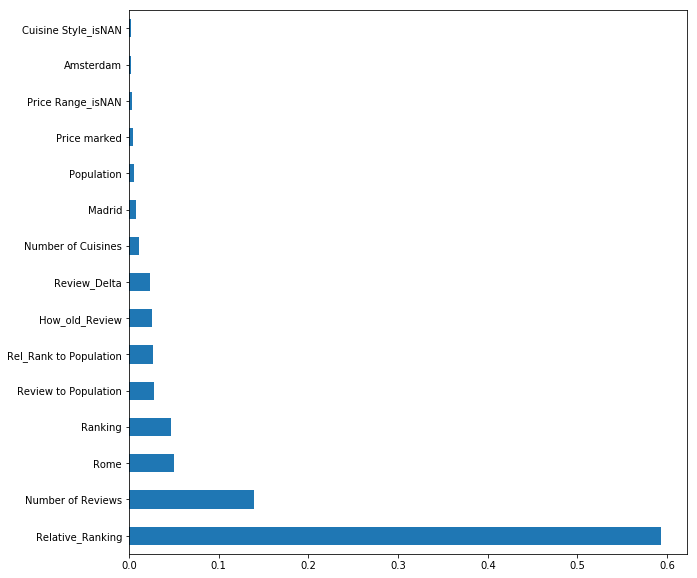

In [73]:
# в RandomForestRegressor есть возможность вывести
# самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Видно, что признак 'Relative_Ranking' - отношение ранга ресторана к количеству ресторанов в городе имеет наибольшее влияние на целевую переменную. 

# Submission


In [74]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Number_of_Reviews_isNAN,Price Range_isNAN,Cuisine Style_isNAN,Amsterdam,Athens,Barcelona,Berlin,...,Warsaw,Zurich,Price marked,Number of Cuisines,Review_Delta,How_old_Review,Relative_Ranking,Population,Review to Population,Rel_Rank to Population
5463,496.0,81.0,0.0,0,0,0,0,0,0,0,...,0,0,1,6,-93,317,0.433188,1471,0.055065,0.000294
6820,646.0,90.0,0.0,0,0,0,0,0,0,0,...,0,0,1,2,8,111,0.867114,507,0.177515,0.001710
3468,274.0,2219.0,0.0,0,0,0,0,0,0,0,...,0,0,2,8,9,50,0.105832,3900,0.568974,0.000027
6813,790.0,90.0,0.0,0,0,0,0,0,0,0,...,0,0,2,4,53,161,0.435022,1301,0.069178,0.000334
1690,278.0,63.0,0.0,0,0,0,0,0,0,0,...,0,0,3,4,486,423,0.471186,496,0.127016,0.000950
8749,2003.0,7.0,0.0,0,1,0,0,0,0,0,...,0,0,2,1,4,50,1.388080,1897,0.003690,0.000732
2645,1964.0,190.0,0.0,0,0,0,0,0,0,0,...,0,0,2,2,28,186,0.321546,10620,0.017891,0.000030
6819,2617.0,109.0,0.0,0,0,0,0,0,0,0,...,0,0,2,2,298,216,0.428454,10620,0.010264,0.000040
7689,3457.0,9.0,0.0,0,0,0,0,0,0,0,...,0,0,1,1,629,454,1.903634,1301,0.006918,0.001463
1382,99.0,522.0,0.0,0,0,0,0,0,0,0,...,0,0,1,6,9,53,0.025964,3266,0.159829,0.000008


In [75]:
test_data = test_data.drop(['Rating'], axis=1)

In [76]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [77]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [78]:
predict_submission

array([3.05 , 4.23 , 4.44 , ..., 3.065, 4.495, 4.35 ])

In [79]:
# округление рейтинга до 0.5
predict_submission = (predict_submission * 2).round() / 2
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [80]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.0
4,id_4,4.5
5,id_5,4.5
6,id_6,3.0
7,id_7,2.0
8,id_8,4.0
9,id_9,4.5


# Выводы:


В данном проекте был проанализирован и подготовлен к моделированию датасет с информацией по ресторанам от TripAdvisor. Работа заключалась в очистке данных, заполнении пропусков и создании новых признаков с целью уменьшить ошибку прогноза рейтинга ресторана. Категориальные признаки, по возможности, были переведены в числовой формат для использования в модели ML.

В датасете были обнаружены пропуски данных в признаках 'Number of Reviews', 'Price Range' и 'Cuisine Style'. Пропуски были заполнены, при этом были созданы новые признаки  'isNAN' с информацией об отсутствии данных.

Категориальный признак 'City' включает в себя 31 город. Больше всего ресторанов (7193) - в Лондоне. Признак был закодирован при помощи функции get_dummies.

Ордерный признак 'Price Range'- 3 градации - заменили последовательными числами 1,2,3. Больше всего ресторанов - в среднем ценовом диапазоне.

Категориальный признак 'Cuisine Style': в датасете 125 уникальных кухонь. Самые распространенные - вегетарианская и европейская. На его основе создан новый признак с количеством кухонь в ресторане.

Из признака 'Reviews' были извлечены даты отзывов. Создан признак с разницей в днях между двумя отзывами, а также признак  "старость ревью относительно самого свежего в днях".

Создан новый признак 'Relative_Ranking'- отношение ранга ресторана к количеству ресторанов в этом городе  по данным датасета. Важно: в итоге этот признак внес наибольший вклад в повышение точности моделирования.

Для создания нового признака 'Population' была найдена в интернете информация о населении городов датасета и введена вручную в виде словаря. На основании этого созданы новые относительные признаки: 'Review to Population' (отношение количества отзывов к населению) и 'Rel_Rank to Population' (отношение относительного ранга к населению). 

Матрица корреляций показала отсутствие мультиколлинеарности, поэтому все признаки были оставлены для дальнейшего использования в модели ML.

Было произведено моделирование с использованием алгоритма машинного обучения  "RandomForestRegression". Округление результатов моделирования (до 0.5, как шаг 'Rating' в исходном датасете) уменьшило абсолютную ошибку. Метрика Mean Absolute Error  показала отклонение MAE=0.16875 от фактических значений. Это меньше, чем MAE из baseline notebook.

Таким образом, описанная выше обработка и feature engineering дали свой эффект и повысили точность моделирования.
 
 








